In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import glob
import numpy as np
import os
import time
import imageio
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, BatchNormalization, LeakyReLU, Dropout, Flatten, Reshape, ReLU

In [3]:
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz

--2020-08-10 06:00:35--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/x-gzip]
Saving to: ‘102flowers.tgz’

102flowers.tgz      100%[===================>] 328.89M  20.6MB/s    in 17s     

2020-08-10 06:00:52 (19.5 MB/s) - ‘102flowers.tgz’ saved [344862509/344862509]



In [4]:
!tar -xzf 102flowers.tgz
!rm -f 102flowers.tgz

In [5]:
for infile in glob.glob('/content/jpg/'+'*.jpg'):
  file, ext = os.path.splitext(infile)
  im = Image.open(infile)
  im = im.resize((128,128))
  os.remove(infile)
  im.save(file+'.jpg')

train_data = []
for image_path in glob.glob('/content/jpg/'+'*.jpg'):
  image = imageio.imread(image_path)
  train_data.append(image)

x_train = np.array(train_data)

x_train = (x_train.astype(np.float32) - 127.5) / 127.5

x_train.shape[0]

8189

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


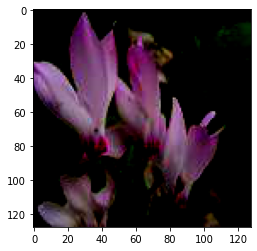

In [6]:
plt.imshow(x_train[4094])

In [7]:
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 64

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
def generator_model():
  model = Sequential()
  model.add(Dense(8*8*256, use_bias=False, input_shape=(100,)))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(Reshape((8,8,256), input_shape=(8*8*256,)))

  model.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
  model.add(BatchNormalization())
  model.add(ReLU())

  model.add(Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
  model.add(BatchNormalization())
  model.add(ReLU())

  model.add(Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False))
  model.add(BatchNormalization())
  model.add(ReLU())
      
  model.add(Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

  #model.summary()
  return model

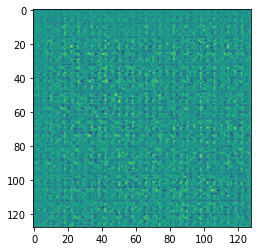

In [10]:
generator = generator_model()
noise = tf.random.normal([1, 100])
generator_image = generator(noise, training = False)
plt.imshow(generator_image[0, :, :, 0])

In [11]:
def discriminator_model():
  model = Sequential()
  model.add(Conv2D(32, 5, strides=(2,2), padding='same', input_shape=(128,128,3)))
  model.add(LeakyReLU())
  model.add(Dropout(0.5))

  model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(Dropout(0.5))

  model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(Dropout(0.5))

  model.add(Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(1))
    
  #model.summary()
  return model

In [12]:
discriminator = discriminator_model()
suspect = discriminator(generator_image)
suspect

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00010967]], dtype=float32)>

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    print(total_loss)
    return total_loss

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [16]:
EPOCHS = 5000
noise_dim = 100
num_examples_to_generate = 10
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [17]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [18]:
from IPython import display

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

In [19]:
%cd '/content/drive/My Drive/GAN1'

/content/drive/My Drive/GAN1


In [20]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  
  fig = plt.figure(figsize=(15,7))
  for i in range(predictions.shape[0]):
      preds = predictions[i,:,:,:]
      preds = np.array(preds)
      preds = (preds * 127.5) + 127.5
      plt.subplot(2, 5, i+1)
      p = (preds).astype(np.uint8)
      plt.imshow(p)
      plt.axis('off')
  if(epoch % 25 == 0):
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.figure().clear()
  plt.close()

In [ ]:
train(train_dataset, EPOCHS)